In [1]:
from utils.alloys import alloy_to_1d_tensor, get_elements_and_compositions, element_to_index
from utils.constants import alloy_max_len, n_elements
from utils.ml import *
from utils.dataframes import dfs_tabs
import matplotlib.pyplot as plt

2023-09-18 11:00:10.414838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 11:00:10.683811: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-18 11:00:11.779261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-09-18 11:00:11.779538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerro

In [2]:
df_train = pd.read_csv("train_final_df.csv")
df_test = pd.read_csv("test_final_df.csv")

# Print the shape of the training and testing sets to check the split sizes
print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)

Training set shape: (1269, 3)
Testing set shape: (318, 3)


In [3]:
# constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ideally a max factor is from the training dataset
max_factor = max(df_train["actual_d_max"])
print(max_factor)

35.0


In [4]:
# creating the input and output data for the model
X_train = []
y_train = []

X_test = []
y_test = []

elements_vector_df = pd.read_csv("utils/elements_wvmodel_2016_12-15-20.csv")

def alloy_to_vectorized_tensor(alloy_str, alloy_max_len = alloy_max_len):
    tensor = torch.zeros(20, 118)
    elements, compositions = get_elements_and_compositions(alloy_str)
    i = 0
    for idx in range(0, len(elements) + len(compositions), 2):
        tensor[idx, element_to_index(elements[i])] = 1
        tensor[idx+1, int(compositions[i])] = 1
        # print(element_to_index(elements[i]), int(compositions[i]))
        i += 1
    return tensor

torch.set_printoptions(profile="full")
print(alloy_to_vectorized_tensor("B6.0Cr16.0Fe78.0"))
torch.set_printoptions(profile="default")

for i in range(df_train.shape[0]):
    X_train.append(alloy_to_vectorized_tensor(df_train.loc[i, "bmg_alloy"]))
    y_train.append(df_train.loc[i, "actual_d_max"] / max_factor)
    
X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

print(X_train.shape, X_train.dtype, y_train.shape, min(y_train).item(), max(y_train).item())

for i in range(df_test.shape[0]):
    X_test.append(alloy_to_vectorized_tensor(df_test.loc[i, "bmg_alloy"]))
    y_test.append(df_test.loc[i, "actual_d_max"] / max_factor)
    
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_test.shape, min(y_test).item(), max(y_test).item())

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

torch.Size([1269, 20, 118]) torch.float32 torch.Size([1269]) 0.0 1.0
torch.Size([318, 20, 118]) 0.0 0.8571428656578064


In [5]:
import torch

# Assuming X_train and X_test are Python lists of data
# Convert them to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

# Calculate mean and standard deviation from the training data along axis 0
mean = torch.mean(X_train, dim=0)
std = torch.std(X_train, dim=0)

epsilon = 1e-8  # You can adjust this value if needed
std = std + epsilon
mean = mean + epsilon
print(mean, std)

# Normalize the data
normalized_X_train = (X_train - mean) / std
normalized_X_test = (X_test - mean) / std

tensor([[1.0000e-08, 1.0000e-08, 1.0000e-08,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        [2.3641e-03, 1.1820e-02, 4.0189e-02,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        [1.0000e-08, 1.0000e-08, 1.0000e-08,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        ...,
        [1.0000e-08, 1.0000e-08, 3.9401e-03,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        [1.0000e-08, 1.0000e-08, 1.0000e-08,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        [1.0000e-08, 1.0000e-08, 1.0000e-08,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08]]) tensor([[1.0000e-08, 1.0000e-08, 1.0000e-08,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        [4.8583e-02, 1.0812e-01, 1.9648e-01,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        [1.0000e-08, 1.0000e-08, 1.0000e-08,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
        ...,
        [1.0000e-08, 1.0000e-08, 6.2671e-02,  ..., 1.0000e-08, 1.0000e-08,
         1.0000e-08],
   

In [6]:
is_nan_train = tf.math.is_nan(normalized_X_train)
print(is_nan_train)

is_nan_test = tf.math.is_nan(normalized_X_test)
print(is_nan_test)

tf.Tensor(
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... Fals

2023-09-18 11:00:17.955639: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-18 11:00:17.955742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (laptop): /proc/driver/nvidia/version does not exist
2023-09-18 11:00:17.957567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        out = self.sigmoid(out)
        return out

# Define the model parameters
input_size = 118
hidden_size = 128
num_layers = 10
output_size = 1

# Create the model
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert your data to PyTorch tensors
X_train = torch.tensor(normalized_X_train, dtype=torch.float32)
X_test = torch.tensor(normalized_X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = y_train.view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = y_test.view(-1, 1)
# Training loop
num_epochs = 5000
print_every = 100
plot_loss = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % print_every == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")
    plot_loss.append(loss.item())

Epoch 0/5000, Loss: 0.6993
Epoch 100/5000, Loss: 0.3200
Epoch 200/5000, Loss: 0.3200
Epoch 300/5000, Loss: 0.3200
Epoch 400/5000, Loss: 0.3200
Epoch 500/5000, Loss: 0.3200
Epoch 600/5000, Loss: 0.3200
Epoch 700/5000, Loss: 0.3200
Epoch 800/5000, Loss: 0.3200
Epoch 900/5000, Loss: 0.3200
Epoch 1000/5000, Loss: 0.3200
Epoch 1100/5000, Loss: 0.3200
Epoch 1200/5000, Loss: 0.3200
Epoch 1300/5000, Loss: 0.3200
Epoch 1400/5000, Loss: 0.3200
Epoch 1500/5000, Loss: 0.3200
Epoch 1600/5000, Loss: 0.3200
Epoch 1700/5000, Loss: 0.3200
Epoch 1800/5000, Loss: 0.3200
Epoch 1900/5000, Loss: 0.3200
Epoch 2000/5000, Loss: 0.3200
Epoch 2100/5000, Loss: 0.3200
Epoch 2200/5000, Loss: 0.3200
Epoch 2300/5000, Loss: 0.3200
Epoch 2400/5000, Loss: 0.3200
Epoch 2500/5000, Loss: 0.3200
Epoch 2600/5000, Loss: 0.3200
Epoch 2700/5000, Loss: 0.3200
Epoch 2800/5000, Loss: 0.3200
Epoch 2900/5000, Loss: 0.3200
Epoch 3000/5000, Loss: 0.3200
Epoch 3100/5000, Loss: 0.3200
Epoch 3200/5000, Loss: 0.3200
Epoch 3300/5000, Loss:

Text(0, 0.5, 'Loss')

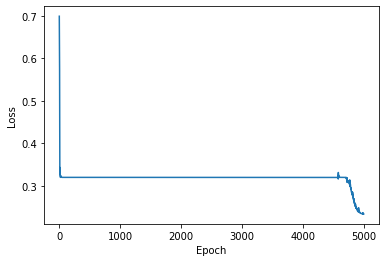

In [8]:
plt.plot(range(len(plot_loss)), plot_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
torch.save(model.state_dict(), "rnn_trainset_trained_method_4.pt")

In [10]:
# Once training is done, you can use the trained model to make predictions
model.eval()
with torch.no_grad():
    predicted_labels = model(X_test)

In [11]:
print(y_train, predicted_labels)

tensor([[0.0000],
        [0.0571],
        [0.0286],
        ...,
        [0.0286],
        [0.0857],
        [0.1429]]) tensor([[0.0061],
        [0.5557],
        [0.0308],
        [0.0721],
        [0.0032],
        [0.0032],
        [0.0032],
        [0.2179],
        [0.0032],
        [0.2701],
        [0.0552],
        [0.0690],
        [0.1385],
        [0.7689],
        [0.1433],
        [0.0032],
        [0.0761],
        [0.0032],
        [0.0801],
        [0.0032],
        [0.0032],
        [0.0032],
        [0.2774],
        [0.0032],
        [0.2035],
        [0.0627],
        [0.0032],
        [0.0273],
        [0.0749],
        [0.1487],
        [0.2265],
        [0.0032],
        [0.0032],
        [0.1356],
        [0.0575],
        [0.2686],
        [0.0032],
        [0.1473],
        [0.0032],
        [0.0032],
        [0.0537],
        [0.1521],
        [0.0032],
        [0.0032],
        [0.0032],
        [0.4668],
        [0.0032],
        [0.1938],
        [0.065

In [12]:
r2 = r2_score(np.array(y_test)*max_factor, np.array(predicted_labels).reshape(-1)*max_factor)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.5842


<AxesSubplot:>

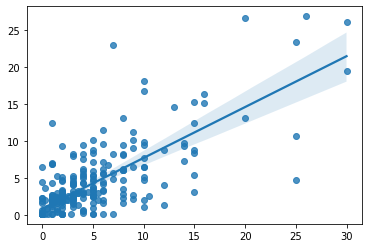

In [13]:
sns.regplot(x=np.array(y_test)*max_factor, y=np.array(predicted_labels).reshape(-1)*max_factor)

In [14]:
all_rnn_train_output = []
for i in range(df_train.shape[0]):
    alloy_tensor = alloy_to_vectorized_tensor(df_train.loc[i, "bmg_alloy"])
    output = model(alloy_tensor.unsqueeze(0))
    all_rnn_train_output.append(output.squeeze().item() * max_factor)

all_rnn_test_output = []
for i in range(df_test.shape[0]):
    alloy_tensor =  alloy_to_vectorized_tensor(df_test.loc[i, "bmg_alloy"])
    output = model(alloy_tensor.unsqueeze(0))
    all_rnn_test_output.append(output.squeeze().item() * max_factor)
    
new_train = df_train
new_test = df_test


new_train["rnn_encoding"] = all_rnn_train_output
new_test["rnn_encoding"] = all_rnn_test_output
    
dfs = [new_train, new_test]
sheets = ["train", "test"]
dfs_tabs(dfs, sheets, 'dataset_rnn.xlsx')

In [15]:
df_train = pd.read_excel("dataset_rnn.xlsx", sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", sheet_name="test")
display(df_train)
display(df_test)

,bmg_alloy,paper_sno,actual_d_max,rnn_encoding
0,B6.0Cr16.0Fe78.0,[9],0.00,0.11
1,B22.3Fe66.9Mo3.72Dy7.0,[9],2.00,0.11
2,Mg11.0Ca55.0Cu23.0Zn11.0,"[5, 7]",1.00,0.11
3,Mg84.5Mn8.0Y7.5,[9],0.00,0.11
4,Al95.0Co3.0Ce2.0,[9],0.00,0.11
...,...,...,...,...
1264,Cu55.0Ga5.0Zr40.0,"[9, 5, 7]",2.00,0.11
1265,B20.0Si4.0Fe71.2Cu0.8Nb4.0,[2],1.00,0.11
1266,Mg25.0Ca55.0Zn20.0,"[9, 5, 7]",1.00,0.11
1267,B6.0C15.0Cr4.0Mn10.0Fe53.0Mo12.0,[2],3.00,0.11


,bmg_alloy,paper_sno,actual_d_max,rnn_encoding
0,Ni50.0Cu40.0Hf10.0,[9],0.00,0.11
1,Al8.0Cu36.0Zr46.0Pd2.0Ag8.0,"[1, 6]",30.00,0.11
2,Al25.0Co20.0Tm55.0,"[5, 7]",3.00,0.11
3,B4.0C4.0Si2.0P10.0Fe75.0Ga3.0Mo2.0,"[1, 2, 5, 6, 9]",2.50,0.11
4,Al2.0Cu90.0Ce8.0,[9],0.00,0.11
...,...,...,...,...
313,B2.0Fe86.0Mo12.0,[9],0.00,0.11
314,Fe42.0Cu41.0Ag17.0,[9],0.00,0.11
315,Be23.0Ti24.0Fe6.0Ni10.0Cu9.0Zr28.0,"[1, 6]",4.00,0.11
316,Mg22.5Ca50.0Cu27.5,"[9, 5, 7]",10.00,0.11


In [16]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
# df_test = df_test.drop(["predicted_d_max"], axis=1)
df_train = df_train.drop(["paper_sno"], axis=1)
df_test = df_test.drop(["paper_sno"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

R2 = []
ADJR2 = []
RMSE = []
names = []
TIME = []

for name, model in tqdm(REGRESSORS):
    start = time.time()
    pipe = Pipeline(steps=[
                        ("classifier", model()),
                    ]
                )
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        r_squared = r2_score(y_test, y_pred)
        print(name, r_squared)
        adj_rsquared = adjusted_rsquared(
            r_squared, X_test.shape[0], X_test.shape[1]
        )
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        names.append(name)
        R2.append(r_squared)
        ADJR2.append(adj_rsquared)
        RMSE.append(rmse)
        TIME.append(time.time() - start)
    except Exception as exception:
        print(name + " model failed to execute")
        print(exception)
    scores = {
                "Model": names,
                "Adjusted R-Squared": ADJR2,
                "R-Squared": R2,
                "RMSE": RMSE,
                "Time Taken": TIME,
            }
    scores = pd.DataFrame(scores)
    scores = scores.sort_values(by = "Adjusted R-Squared", ascending = False).set_index("Model")

 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 51.62it/s]

AdaBoostRegressor -0.05388750079125315
BaggingRegressor 0.07488975825139943
BayesianRidge -0.005335325196012208
DecisionTreeRegressor 0.05459040774971846
DummyRegressor -0.005335325313598593
ElasticNet -0.005335325313598593
ElasticNetCV -0.004904393598245793
ExtraTreeRegressor -0.06904988507057785
ExtraTreesRegressor -0.030138105056108477
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor 0.0793547372829766
GradientBoostingRegressor 0.06927833991828114


 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 26.85it/s]

HistGradientBoostingRegressor -0.011394579115697967
HuberRegressor -0.11199241565794926
KNeighborsRegressor -0.11548713322553783
KernelRidge -0.012697671559399604
Lars 0.07940473411252003
LarsCV 0.07940473411252003
Lasso -0.005335325313598593
LassoCV 0.07939719409481616
LassoLars -0.005335325313598593
LassoLarsCV 0.07940473411252003
LassoLarsIC 0.07940473411252003
LinearRegression 0.07940473411242843
LinearSVR -0.12283894314268196


 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:01<00:00, 24.91it/s]

MLPRegressor -0.005426827760908193
NuSVR 0.026483267077898165
OrthogonalMatchingPursuit 0.07940473411243876
OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor -0.11934241203296247
PoissonRegressor -0.005335325313598593
RANSACRegressor -0.4027308996959904


 79%|█████████████████████████████████████████████████████████████████▏                 | 33/42 [00:01<00:00, 26.43it/s]

RandomForestRegressor 0.07560198613854152
Ridge -0.005335322507117324
RidgeCV -0.005335297248791893
SGDRegressor -0.0050465013834026795
SVR -0.012321537687704165
TransformedTargetRegressor 0.07940473411242843
TweedieRegressor -0.005335325313598593


 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 20.91it/s]

XGBRegressor -0.22564537372420257
LGBMRegressor -0.0006119593674780432
Learning rate set to 0.042513
0:	learn: 4.9500619	total: 52.8ms	remaining: 52.8s
1:	learn: 4.9275083	total: 53.5ms	remaining: 26.7s
2:	learn: 4.9077246	total: 54.2ms	remaining: 18s
3:	learn: 4.8869349	total: 54.8ms	remaining: 13.6s
4:	learn: 4.8705324	total: 55.4ms	remaining: 11s
5:	learn: 4.8538837	total: 56ms	remaining: 9.27s
6:	learn: 4.8406620	total: 56.5ms	remaining: 8.02s
7:	learn: 4.8247869	total: 57.1ms	remaining: 7.08s
8:	learn: 4.8123234	total: 57.7ms	remaining: 6.36s
9:	learn: 4.7985138	total: 58.3ms	remaining: 5.77s
10:	learn: 4.7870176	total: 58.9ms	remaining: 5.29s
11:	learn: 4.7767160	total: 59.4ms	remaining: 4.89s
12:	learn: 4.7665932	total: 60ms	remaining: 4.56s
13:	learn: 4.7574065	total: 60.6ms	remaining: 4.27s
14:	learn: 4.7477729	total: 61.2ms	remaining: 4.02s
15:	learn: 4.7382891	total: 61.7ms	remaining: 3.8s
16:	learn: 4.7309109	total: 62.4ms	remaining: 3.61s
17:	learn: 4.7240432	total: 62.9ms

474:	learn: 4.2889013	total: 293ms	remaining: 324ms
475:	learn: 4.2883930	total: 294ms	remaining: 323ms
476:	learn: 4.2875448	total: 294ms	remaining: 323ms
477:	learn: 4.2874591	total: 295ms	remaining: 322ms
478:	learn: 4.2873529	total: 295ms	remaining: 321ms
479:	learn: 4.2866298	total: 296ms	remaining: 321ms
480:	learn: 4.2860984	total: 296ms	remaining: 320ms
481:	learn: 4.2854776	total: 297ms	remaining: 319ms
482:	learn: 4.2851585	total: 298ms	remaining: 318ms
483:	learn: 4.2849933	total: 298ms	remaining: 318ms
484:	learn: 4.2846731	total: 299ms	remaining: 317ms
485:	learn: 4.2839600	total: 299ms	remaining: 316ms
486:	learn: 4.2837053	total: 300ms	remaining: 316ms
487:	learn: 4.2830818	total: 300ms	remaining: 315ms
488:	learn: 4.2823287	total: 301ms	remaining: 314ms
489:	learn: 4.2814965	total: 301ms	remaining: 314ms
490:	learn: 4.2800418	total: 302ms	remaining: 313ms
491:	learn: 4.2799970	total: 302ms	remaining: 312ms
492:	learn: 4.2793273	total: 303ms	remaining: 311ms
493:	learn: 

100%|███████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 17.36it/s]

813:	learn: 4.1875413	total: 477ms	remaining: 109ms
814:	learn: 4.1875211	total: 478ms	remaining: 109ms
815:	learn: 4.1871642	total: 479ms	remaining: 108ms
816:	learn: 4.1867830	total: 479ms	remaining: 107ms
817:	learn: 4.1865598	total: 480ms	remaining: 107ms
818:	learn: 4.1859944	total: 480ms	remaining: 106ms
819:	learn: 4.1854654	total: 481ms	remaining: 106ms
820:	learn: 4.1853850	total: 481ms	remaining: 105ms
821:	learn: 4.1853446	total: 482ms	remaining: 104ms
822:	learn: 4.1847408	total: 483ms	remaining: 104ms
823:	learn: 4.1846740	total: 483ms	remaining: 103ms
824:	learn: 4.1846453	total: 484ms	remaining: 103ms
825:	learn: 4.1846275	total: 484ms	remaining: 102ms
826:	learn: 4.1844983	total: 485ms	remaining: 101ms
827:	learn: 4.1843098	total: 485ms	remaining: 101ms
828:	learn: 4.1842325	total: 486ms	remaining: 100ms
829:	learn: 4.1839903	total: 486ms	remaining: 99.6ms
830:	learn: 4.1837133	total: 487ms	remaining: 99ms
831:	learn: 4.1833348	total: 487ms	remaining: 98.4ms
832:	learn:

In [17]:
display(scores)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLarsCV,0.08,0.08,4.91,0.01
Lars,0.08,0.08,4.91,0.01
LassoLarsIC,0.08,0.08,4.91,0.01
LarsCV,0.08,0.08,4.91,0.01
OrthogonalMatchingPursuit,0.08,0.08,4.91,0.00
TransformedTargetRegressor,0.08,0.08,4.91,0.00
LinearRegression,0.08,0.08,4.91,0.00
LassoCV,0.08,0.08,4.91,0.06
GaussianProcessRegressor,0.08,0.08,4.91,0.11


In [18]:
df_train = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="train")
df_test = pd.read_excel("dataset_rnn.xlsx", index_col=0, sheet_name="test")
# df_test = df_test.drop(["predicted_d_max"], axis=1)
df_train = df_train.drop(["paper_sno"], axis=1)
df_test = df_test.drop(["paper_sno"], axis=1)
X_train, y_train = df_train.loc[:, df_train.columns != "actual_d_max"], pd.DataFrame(df_train["actual_d_max"])
X_test, y_test = df_test.loc[:, df_test.columns != "actual_d_max"], pd.DataFrame(df_test["actual_d_max"])

R2 = []
ADJR2 = []
RMSE = []
names = []
TIME = []

for transformer_method_name, transformer_method in tqdm(TRANSFOMER_METHODS):
    for name, model in tqdm(REGRESSORS):
        start = time.time()
        X_transformer = transformer_method()
        y_transformer = transformer_method()
        transformed_X_train = pd.DataFrame(X_transformer.fit_transform(X_train), columns = X_train.columns)
        transformed_X_test = pd.DataFrame(X_transformer.transform(X_test), columns = X_test.columns)

        transformed_y_train = pd.DataFrame(y_transformer.fit_transform(y_train), columns = y_train.columns)
        transformed_y_test = pd.DataFrame(y_transformer.transform(y_test), columns = y_test.columns)
        pipe = Pipeline(steps=[
                            ("classifier", model()),
                        ]
                    )
        try:
            pipe.fit(transformed_X_train, transformed_y_train)
            transformed_y_pred = pipe.predict(transformed_X_test)
            r_squared = r2_score(transformed_y_test, transformed_y_pred)
            adj_rsquared = adjusted_rsquared(
                r_squared, transformed_X_test.shape[0], transformed_X_test.shape[1]
            )
            rmse = np.sqrt(mean_squared_error(transformed_y_test, transformed_y_pred))
            names.append(name + " (" + transformer_method_name + ")")
            print(name + " (" + transformer_method_name + ")", r_squared)
            R2.append(r_squared)
            ADJR2.append(adj_rsquared)
            RMSE.append(rmse)
            TIME.append(time.time() - start)
        except Exception as exception:
            print(name + " (" + transformer_method_name + ")" + " model failed to execute")
            print(exception)
        scores = {
                    "Model": names,
                    "Adjusted R-Squared": ADJR2,
                    "R-Squared": R2,
                    "RMSE": RMSE,
                    "Time Taken": TIME,
                }
        scores = pd.DataFrame(scores)
        scores = scores.sort_values(by = "Adjusted R-Squared", ascending = False).set_index("Model")

 17%|██████████████                                                                      | 7/42 [00:00<00:00, 57.83it/s]

AdaBoostRegressor (StandardScaler) -0.2346032231298636
BaggingRegressor (StandardScaler) -0.10587151005072482
BayesianRidge (StandardScaler) 0.07932756777133088
DecisionTreeRegressor (StandardScaler) -0.2896576592164084
DummyRegressor (StandardScaler) -0.005335325313598593
ElasticNet (StandardScaler) -0.005335325313598593
ElasticNetCV (StandardScaler) 0.07939278901744284
ExtraTreeRegressor (StandardScaler) -0.27923540592064433
ExtraTreesRegressor (StandardScaler) -0.2663126134648228
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (StandardScaler) -62.08175175305054
GradientBoostingRegressor (StandardScaler) 0.012053798467645871



 43%|███████████████████████████████████▌                                               | 18/42 [00:00<00:01, 23.45it/s]

HistGradientBoostingRegressor (StandardScaler) -0.011394578951505085
HuberRegressor (StandardScaler) -0.01704001655773202
KNeighborsRegressor (StandardScaler) -0.11684068649153834
KernelRidge (StandardScaler) 0.07939881002698446
Lars (StandardScaler) 0.07940473411245719
LarsCV (StandardScaler) 0.07940473411245719
Lasso (StandardScaler) -0.005335325313598593
LassoCV (StandardScaler) 0.0793971940948417
LassoLars (StandardScaler) -0.005335325313598593
LassoLarsCV (StandardScaler) 0.07940473411245719



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:00<00:00, 33.02it/s]

LassoLarsIC (StandardScaler) 0.07940473411245719
LinearRegression (StandardScaler) 0.07940473411245719
LinearSVR (StandardScaler) -0.04608952671814315



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:01<00:00, 17.51it/s]

MLPRegressor (StandardScaler) 0.10531081913592055
NuSVR (StandardScaler) 0.022677924089554824
OrthogonalMatchingPursuit (StandardScaler) 0.07940473411245719
OrthogonalMatchingPursuitCV (StandardScaler) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (StandardScaler) -1.282398804383134
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (StandardScaler) -0.14768920441585043



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 24.55it/s]

RandomForestRegressor (StandardScaler) -0.10674975552682242
Ridge (StandardScaler) 0.07939881002696181
RidgeCV (StandardScaler) 0.07934166185769409
SGDRegressor (StandardScaler) 0.07905268131942156
SVR (StandardScaler) -0.015483975718940668
TransformedTargetRegressor (StandardScaler) 0.07940473411245719
TweedieRegressor (StandardScaler) 0.056354034181851476
XGBRegressor (StandardScaler) -0.22147536100461274
LGBMRegressor (StandardScaler) -0.0021632624868312966
Learning rate set to 0.042513
0:	learn: 0.9953167	total: 681us	remaining: 680ms
1:	learn: 0.9907818	total: 1.19ms	remaining: 594ms
2:	learn: 0.9868038	total: 1.69ms	remaining: 562ms
3:	learn: 0.9826236	total: 2.15ms	remaining: 536ms
4:	learn: 0.9793255	total: 2.58ms	remaining: 514ms
5:	learn: 0.9759780	total: 3.03ms	remaining: 501ms
6:	learn: 0.9733195	total: 3.46ms	remaining: 490ms
7:	learn: 0.9701274	total: 3.9ms	remaining: 483ms
8:	learn: 0.9676214	total: 4.34ms	remaining: 478ms
9:	learn: 0.9648447	total: 4.77ms	remaining: 472

400:	learn: 0.8693917	total: 204ms	remaining: 305ms
401:	learn: 0.8691803	total: 205ms	remaining: 305ms
402:	learn: 0.8689808	total: 206ms	remaining: 305ms
403:	learn: 0.8688248	total: 206ms	remaining: 304ms
404:	learn: 0.8686254	total: 207ms	remaining: 304ms
405:	learn: 0.8685888	total: 207ms	remaining: 303ms
406:	learn: 0.8683867	total: 208ms	remaining: 303ms
407:	learn: 0.8682144	total: 208ms	remaining: 302ms
408:	learn: 0.8682021	total: 209ms	remaining: 302ms
409:	learn: 0.8681668	total: 209ms	remaining: 301ms
410:	learn: 0.8679701	total: 210ms	remaining: 301ms
411:	learn: 0.8679432	total: 211ms	remaining: 301ms
412:	learn: 0.8677707	total: 211ms	remaining: 300ms
413:	learn: 0.8677497	total: 212ms	remaining: 300ms
414:	learn: 0.8675707	total: 212ms	remaining: 299ms
415:	learn: 0.8674924	total: 213ms	remaining: 299ms
416:	learn: 0.8674707	total: 214ms	remaining: 299ms
417:	learn: 0.8674413	total: 214ms	remaining: 298ms
418:	learn: 0.8673157	total: 215ms	remaining: 298ms
419:	learn: 

 17%|██████████████▏                                                                      | 1/6 [00:02<00:11,  2.36s/it]

739:	learn: 0.8448538	total: 388ms	remaining: 136ms
740:	learn: 0.8448432	total: 389ms	remaining: 136ms
741:	learn: 0.8447622	total: 390ms	remaining: 135ms
742:	learn: 0.8447305	total: 390ms	remaining: 135ms
743:	learn: 0.8447169	total: 391ms	remaining: 134ms
744:	learn: 0.8447073	total: 391ms	remaining: 134ms
745:	learn: 0.8447000	total: 392ms	remaining: 133ms
746:	learn: 0.8446176	total: 392ms	remaining: 133ms
747:	learn: 0.8445709	total: 393ms	remaining: 132ms
748:	learn: 0.8445627	total: 393ms	remaining: 132ms
749:	learn: 0.8445570	total: 394ms	remaining: 131ms
750:	learn: 0.8445478	total: 394ms	remaining: 131ms
751:	learn: 0.8444884	total: 395ms	remaining: 130ms
752:	learn: 0.8444663	total: 395ms	remaining: 130ms
753:	learn: 0.8443825	total: 396ms	remaining: 129ms
754:	learn: 0.8442923	total: 396ms	remaining: 129ms
755:	learn: 0.8442840	total: 397ms	remaining: 128ms
756:	learn: 0.8442100	total: 398ms	remaining: 128ms
757:	learn: 0.8441801	total: 398ms	remaining: 127ms
758:	learn: 


 17%|██████████████                                                                      | 7/42 [00:00<00:00, 57.65it/s]

AdaBoostRegressor (MinMaxScaler) -0.43713924119685577
BaggingRegressor (MinMaxScaler) -0.10713137078007828
BayesianRidge (MinMaxScaler) 0.0793275667154194
DecisionTreeRegressor (MinMaxScaler) -0.2896576592164082
DummyRegressor (MinMaxScaler) -0.005335325313598371
ElasticNet (MinMaxScaler) -0.005335325313598371
ElasticNetCV (MinMaxScaler) 0.07939084900670546
ExtraTreeRegressor (MinMaxScaler) -0.276135349545682
ExtraTreesRegressor (MinMaxScaler) -0.2694042838781887
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MinMaxScaler) 0.11445372468911419
GradientBoostingRegressor (MinMaxScaler) 0.012053798467646093



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 26.92it/s]

HistGradientBoostingRegressor (MinMaxScaler) -0.011394579338276811
HuberRegressor (MinMaxScaler) -0.01704185931204405
KNeighborsRegressor (MinMaxScaler) -0.11146734448530249
KernelRidge (MinMaxScaler) 0.07693837384932412
Lars (MinMaxScaler) 0.07940473411248739
LarsCV (MinMaxScaler) 0.07940473411248739
Lasso (MinMaxScaler) -0.005335325313598371
LassoCV (MinMaxScaler) 0.07939719409487178
LassoLars (MinMaxScaler) -0.005335325313598371
LassoLarsCV (MinMaxScaler) 0.07940473411248739
LassoLarsIC (MinMaxScaler) 0.07940473411248739
LinearRegression (MinMaxScaler) 0.07940473411248739
LinearSVR (MinMaxScaler) -0.05100584515545603



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:01<00:00, 31.34it/s]

MLPRegressor (MinMaxScaler) 0.08815157189103451
NuSVR (MinMaxScaler) 0.0040185882902132875
OrthogonalMatchingPursuit (MinMaxScaler) 0.07940473411248739
OrthogonalMatchingPursuitCV (MinMaxScaler) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (MinMaxScaler) -22.113015322810046
PoissonRegressor (MinMaxScaler) -0.00510314453922045
RANSACRegressor (MinMaxScaler) -0.4506006131611551



 98%|█████████████████████████████████████████████████████████████████████████████████  | 41/42 [00:01<00:00, 34.04it/s]

RandomForestRegressor (MinMaxScaler) -0.10559191177940064
Ridge (MinMaxScaler) 0.0785276226721835
RidgeCV (MinMaxScaler) 0.07934595877996331
SGDRegressor (MinMaxScaler) 0.022070301996841457
SVR (MinMaxScaler) 0.057391221876993415
TransformedTargetRegressor (MinMaxScaler) 0.07940473411248739
TweedieRegressor (MinMaxScaler) -0.003631066892678003
XGBRegressor (MinMaxScaler) -0.2045273935499441
LGBMRegressor (MinMaxScaler) -0.0006119639616313233
Learning rate set to 0.042513
0:	learn: 0.1414303	total: 529us	remaining: 529ms
1:	learn: 0.1407860	total: 972us	remaining: 485ms
2:	learn: 0.1402207	total: 1.39ms	remaining: 463ms
3:	learn: 0.1396267	total: 1.8ms	remaining: 448ms
4:	learn: 0.1391581	total: 2.19ms	remaining: 437ms
5:	learn: 0.1386824	total: 2.6ms	remaining: 431ms
6:	learn: 0.1383046	total: 3.01ms	remaining: 427ms
7:	learn: 0.1378511	total: 3.41ms	remaining: 423ms
8:	learn: 0.1374950	total: 3.83ms	remaining: 422ms
9:	learn: 0.1371004	total: 4.25ms	remaining: 421ms
10:	learn: 0.13677

432:	learn: 0.1230523	total: 224ms	remaining: 293ms
433:	learn: 0.1230498	total: 224ms	remaining: 293ms
434:	learn: 0.1230452	total: 225ms	remaining: 292ms
435:	learn: 0.1230215	total: 225ms	remaining: 292ms
436:	learn: 0.1230188	total: 226ms	remaining: 291ms
437:	learn: 0.1229925	total: 227ms	remaining: 291ms
438:	learn: 0.1229903	total: 227ms	remaining: 290ms
439:	learn: 0.1229875	total: 228ms	remaining: 290ms
440:	learn: 0.1229617	total: 228ms	remaining: 289ms
441:	learn: 0.1229345	total: 229ms	remaining: 289ms
442:	learn: 0.1229331	total: 229ms	remaining: 288ms
443:	learn: 0.1229088	total: 230ms	remaining: 288ms
444:	learn: 0.1228948	total: 230ms	remaining: 287ms
445:	learn: 0.1228924	total: 231ms	remaining: 287ms
446:	learn: 0.1228819	total: 231ms	remaining: 286ms
447:	learn: 0.1228575	total: 232ms	remaining: 286ms
448:	learn: 0.1228347	total: 232ms	remaining: 285ms
449:	learn: 0.1228327	total: 233ms	remaining: 284ms
450:	learn: 0.1228229	total: 233ms	remaining: 284ms
451:	learn: 

 33%|████████████████████████████▎                                                        | 2/6 [00:04<00:08,  2.11s/it]

780:	learn: 0.1198040	total: 408ms	remaining: 114ms
781:	learn: 0.1198012	total: 409ms	remaining: 114ms
782:	learn: 0.1197748	total: 409ms	remaining: 113ms
783:	learn: 0.1197720	total: 410ms	remaining: 113ms
784:	learn: 0.1197709	total: 411ms	remaining: 112ms
785:	learn: 0.1197698	total: 411ms	remaining: 112ms
786:	learn: 0.1197641	total: 412ms	remaining: 111ms
787:	learn: 0.1197605	total: 412ms	remaining: 111ms
788:	learn: 0.1197593	total: 413ms	remaining: 110ms
789:	learn: 0.1197559	total: 414ms	remaining: 110ms
790:	learn: 0.1197471	total: 414ms	remaining: 109ms
791:	learn: 0.1197462	total: 415ms	remaining: 109ms
792:	learn: 0.1197438	total: 415ms	remaining: 108ms
793:	learn: 0.1197429	total: 416ms	remaining: 108ms
794:	learn: 0.1197347	total: 416ms	remaining: 107ms
795:	learn: 0.1197286	total: 417ms	remaining: 107ms
796:	learn: 0.1197282	total: 417ms	remaining: 106ms
797:	learn: 0.1197205	total: 418ms	remaining: 106ms
798:	learn: 0.1197197	total: 418ms	remaining: 105ms
799:	learn: 


  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (MaxAbsScaler) -0.1646176008632445
BaggingRegressor (MaxAbsScaler) -0.20030973623542137



 17%|██████████████                                                                      | 7/42 [00:00<00:00, 62.71it/s]

BayesianRidge (MaxAbsScaler) 0.07932756548301367
DecisionTreeRegressor (MaxAbsScaler) -0.2896576592164084
DummyRegressor (MaxAbsScaler) -0.005335325313598371
ElasticNet (MaxAbsScaler) -0.005335325313598371
ElasticNetCV (MaxAbsScaler) 0.05240841508231653
ExtraTreeRegressor (MaxAbsScaler) -0.30146325089543313
ExtraTreesRegressor (MaxAbsScaler) -0.2656677927594129
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (MaxAbsScaler) 0.079412857752024
GradientBoostingRegressor (MaxAbsScaler) 0.012053798467646093



 43%|███████████████████████████████████▌                                               | 18/42 [00:00<00:00, 24.36it/s]

HistGradientBoostingRegressor (MaxAbsScaler) -0.011394579338276811
HuberRegressor (MaxAbsScaler) -0.11198570881915759
KNeighborsRegressor (MaxAbsScaler) -0.11898160866449259
KernelRidge (MaxAbsScaler) -0.005397969662109592
Lars (MaxAbsScaler) 0.07940473411222382
LarsCV (MaxAbsScaler) 0.07940473411222382
Lasso (MaxAbsScaler) -0.005335325313598371
LassoCV (MaxAbsScaler) 0.07939719409481971
LassoLars (MaxAbsScaler) -0.005335325313598371
LassoLarsCV (MaxAbsScaler) 0.07940473411222382



 60%|█████████████████████████████████████████████████▍                                 | 25/42 [00:00<00:00, 33.91it/s]

LassoLarsIC (MaxAbsScaler) 0.07940473411222382
LinearRegression (MaxAbsScaler) 0.07940473411222382
LinearSVR (MaxAbsScaler) -0.12283344649638073
MLPRegressor (MaxAbsScaler) -0.0046048507256262194



 81%|███████████████████████████████████████████████████████████████████▏               | 34/42 [00:01<00:00, 28.11it/s]

NuSVR (MaxAbsScaler) 0.002831709861357501
OrthogonalMatchingPursuit (MaxAbsScaler) 0.07940473411222382
OrthogonalMatchingPursuitCV (MaxAbsScaler) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (MaxAbsScaler) -3.6934336117410727
PoissonRegressor (MaxAbsScaler) -0.005335325313598371
RANSACRegressor (MaxAbsScaler) -0.4929546392969433
RandomForestRegressor (MaxAbsScaler) -0.09752108490372957
Ridge (MaxAbsScaler) -0.005335100517361191
RidgeCV (MaxAbsScaler) -0.005333077392685626
SGDRegressor (MaxAbsScaler) -0.005590849467426606



 95%|███████████████████████████████████████████████████████████████████████████████    | 40/42 [00:01<00:00, 34.74it/s]

SVR (MaxAbsScaler) 0.05700676352358558
TransformedTargetRegressor (MaxAbsScaler) 0.07940473411222382
TweedieRegressor (MaxAbsScaler) -0.005335325313598371
XGBRegressor (MaxAbsScaler) -0.21275005790260826
LGBMRegressor (MaxAbsScaler) -0.0006119639616313233
Learning rate set to 0.042513
0:	learn: 0.1414303	total: 549us	remaining: 549ms
1:	learn: 0.1407860	total: 1.03ms	remaining: 515ms
2:	learn: 0.1402207	total: 1.46ms	remaining: 486ms
3:	learn: 0.1396267	total: 1.9ms	remaining: 473ms
4:	learn: 0.1391581	total: 2.34ms	remaining: 466ms
5:	learn: 0.1386824	total: 2.81ms	remaining: 465ms
6:	learn: 0.1383046	total: 3.23ms	remaining: 459ms
7:	learn: 0.1378511	total: 3.66ms	remaining: 454ms
8:	learn: 0.1374950	total: 4.11ms	remaining: 452ms
9:	learn: 0.1371004	total: 4.54ms	remaining: 449ms
10:	learn: 0.1367719	total: 5.02ms	remaining: 452ms
11:	learn: 0.1364776	total: 5.48ms	remaining: 451ms
12:	learn: 0.1361884	total: 5.95ms	remaining: 451ms
13:	learn: 0.1359259	total: 6.43ms	remaining: 453m

192:	learn: 0.1276025	total: 98.7ms	remaining: 413ms
193:	learn: 0.1275970	total: 99.4ms	remaining: 413ms
194:	learn: 0.1275317	total: 100ms	remaining: 413ms
195:	learn: 0.1275021	total: 101ms	remaining: 413ms
196:	learn: 0.1274466	total: 101ms	remaining: 413ms
197:	learn: 0.1274345	total: 102ms	remaining: 413ms
198:	learn: 0.1273931	total: 102ms	remaining: 412ms
199:	learn: 0.1273130	total: 103ms	remaining: 412ms
200:	learn: 0.1273058	total: 103ms	remaining: 411ms
201:	learn: 0.1272926	total: 104ms	remaining: 410ms
202:	learn: 0.1272807	total: 104ms	remaining: 410ms
203:	learn: 0.1272731	total: 105ms	remaining: 409ms
204:	learn: 0.1272675	total: 105ms	remaining: 408ms
205:	learn: 0.1272145	total: 106ms	remaining: 408ms
206:	learn: 0.1271809	total: 106ms	remaining: 407ms
207:	learn: 0.1271408	total: 107ms	remaining: 407ms
208:	learn: 0.1271190	total: 107ms	remaining: 407ms
209:	learn: 0.1271116	total: 108ms	remaining: 406ms
210:	learn: 0.1270550	total: 108ms	remaining: 406ms
211:	learn

543:	learn: 0.1216806	total: 283ms	remaining: 238ms
544:	learn: 0.1216639	total: 284ms	remaining: 237ms
545:	learn: 0.1216460	total: 285ms	remaining: 237ms
546:	learn: 0.1216396	total: 285ms	remaining: 236ms
547:	learn: 0.1216378	total: 286ms	remaining: 236ms
548:	learn: 0.1216317	total: 287ms	remaining: 235ms
549:	learn: 0.1216257	total: 287ms	remaining: 235ms
550:	learn: 0.1216155	total: 288ms	remaining: 234ms
551:	learn: 0.1215988	total: 288ms	remaining: 234ms
552:	learn: 0.1215950	total: 289ms	remaining: 233ms
553:	learn: 0.1215637	total: 289ms	remaining: 233ms
554:	learn: 0.1215484	total: 290ms	remaining: 232ms
555:	learn: 0.1215433	total: 290ms	remaining: 232ms
556:	learn: 0.1215336	total: 291ms	remaining: 231ms
557:	learn: 0.1214985	total: 291ms	remaining: 231ms
558:	learn: 0.1214977	total: 292ms	remaining: 230ms
559:	learn: 0.1214963	total: 292ms	remaining: 230ms
560:	learn: 0.1214942	total: 293ms	remaining: 229ms
561:	learn: 0.1214925	total: 293ms	remaining: 229ms
562:	learn: 

 50%|██████████████████████████████████████████▌                                          | 3/6 [00:06<00:06,  2.04s/it]

893:	learn: 0.1192039	total: 467ms	remaining: 55.4ms
894:	learn: 0.1191977	total: 468ms	remaining: 54.9ms
895:	learn: 0.1191828	total: 469ms	remaining: 54.4ms
896:	learn: 0.1191807	total: 469ms	remaining: 53.9ms
897:	learn: 0.1191778	total: 470ms	remaining: 53.3ms
898:	learn: 0.1191706	total: 470ms	remaining: 52.8ms
899:	learn: 0.1191656	total: 471ms	remaining: 52.3ms
900:	learn: 0.1191619	total: 471ms	remaining: 51.8ms
901:	learn: 0.1191583	total: 472ms	remaining: 51.3ms
902:	learn: 0.1191493	total: 472ms	remaining: 50.7ms
903:	learn: 0.1191347	total: 473ms	remaining: 50.2ms
904:	learn: 0.1191320	total: 473ms	remaining: 49.7ms
905:	learn: 0.1191247	total: 474ms	remaining: 49.2ms
906:	learn: 0.1191227	total: 475ms	remaining: 48.7ms
907:	learn: 0.1191163	total: 475ms	remaining: 48.1ms
908:	learn: 0.1191027	total: 476ms	remaining: 47.6ms
909:	learn: 0.1191006	total: 476ms	remaining: 47.1ms
910:	learn: 0.1191002	total: 477ms	remaining: 46.6ms
911:	learn: 0.1190979	total: 477ms	remaining: 


  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (Normalizer) -0.00040785317681746314
BaggingRegressor (Normalizer) -0.0029666530481553544
BayesianRidge (Normalizer) -0.0011357864129786233
DecisionTreeRegressor (Normalizer) -0.0011357864129786233
DummyRegressor (Normalizer) -0.0011357864129786233
ElasticNet (Normalizer) -0.0011357864129786233
ElasticNetCV (Normalizer) -0.0011357864129786233
ExtraTreeRegressor (Normalizer) -0.0011357864129786233



 21%|██████████████████                                                                  | 9/42 [00:00<00:00, 57.64it/s]

ExtraTreesRegressor (Normalizer) -0.0011357864129781792
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (Normalizer) -0.0010491464235922177
GradientBoostingRegressor (Normalizer) -0.0011357864129786233



 36%|█████████████████████████████▋                                                     | 15/42 [00:00<00:00, 36.07it/s]

HistGradientBoostingRegressor (Normalizer) -0.0011357864129786233
HuberRegressor (Normalizer) -0.46357390401438403
KNeighborsRegressor (Normalizer) -0.3579084967320256
KernelRidge (Normalizer) -0.0012124833400128932
Lars (Normalizer) -0.0011357864129786233
LarsCV (Normalizer) model failed to execute
x and y arrays must have at least 2 entries
Lasso (Normalizer) -0.0011357864129786233



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 36.96it/s]

LassoCV (Normalizer) -0.0011357864129786233
LassoLars (Normalizer) -0.0011357864129786233
LassoLarsCV (Normalizer) model failed to execute
x and y arrays must have at least 2 entries
LassoLarsIC (Normalizer) -0.0011357864129786233
LinearRegression (Normalizer) -0.0011357864129786233
LinearSVR (Normalizer) -0.4722222222222219



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:00<00:00, 40.55it/s]

MLPRegressor (Normalizer) -0.0005084559233119457



 74%|█████████████████████████████████████████████████████████████▎                     | 31/42 [00:00<00:00, 40.58it/s]

NuSVR (Normalizer) -0.14746732026143783
OrthogonalMatchingPursuit (Normalizer) -0.0011357864129786233
OrthogonalMatchingPursuitCV (Normalizer) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (Normalizer) -0.47222222222234045
PoissonRegressor (Normalizer) -0.0011357864129784012
RANSACRegressor (Normalizer) -0.4722222222222219



 86%|███████████████████████████████████████████████████████████████████████▏           | 36/42 [00:00<00:00, 40.99it/s]

RandomForestRegressor (Normalizer) -0.0011063928173811188
Ridge (Normalizer) -0.0011357864129786233
RidgeCV (Normalizer) -0.0011357864129786233
SGDRegressor (Normalizer) -0.00034456972190022306
SVR (Normalizer) -0.22367647058823503
TransformedTargetRegressor (Normalizer) -0.0011357864129786233


 67%|████████████████████████████████████████████████████████▋                            | 4/6 [00:07<00:03,  1.62s/it]

TweedieRegressor (Normalizer) -0.0011357864129784012
XGBRegressor (Normalizer) -0.0011357984724946757
LGBMRegressor (Normalizer) -0.0011357864129786233
CatBoostRegressor (Normalizer) model failed to execute
catboost/libs/data/quantization.cpp:2416: All features are either constant or ignored.



  0%|                                                                                            | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor (QuantileTransformer) 0.09988796760287255
BaggingRegressor (QuantileTransformer) -0.07778294979994627
BayesianRidge (QuantileTransformer) 0.08056856018538883
DecisionTreeRegressor (QuantileTransformer) -0.1340430930945804



 14%|████████████                                                                        | 6/42 [00:00<00:00, 58.45it/s]

DummyRegressor (QuantileTransformer) -0.005230262804975183
ElasticNet (QuantileTransformer) -0.005230262804975183
ElasticNetCV (QuantileTransformer) 0.08091498568314559
ExtraTreeRegressor (QuantileTransformer) -0.12376899431746469
ExtraTreesRegressor (QuantileTransformer) -0.12559922301634963
GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (QuantileTransformer) 0.13373344323461156



 29%|███████████████████████▋                                                           | 12/42 [00:00<00:01, 23.20it/s]

GradientBoostingRegressor (QuantileTransformer) 0.08733941847920257



 38%|███████████████████████████████▌                                                   | 16/42 [00:00<00:01, 18.83it/s]

HistGradientBoostingRegressor (QuantileTransformer) 0.059965203035046044
HuberRegressor (QuantileTransformer) 0.08578784766587377
KNeighborsRegressor (QuantileTransformer) -0.05923956153230514
KernelRidge (QuantileTransformer) -0.037497170098333754
Lars (QuantileTransformer) 0.08096836743894054
LarsCV (QuantileTransformer) 0.08096836743894054
Lasso (QuantileTransformer) -0.005230262804975183



 62%|███████████████████████████████████████████████████▍                               | 26/42 [00:01<00:00, 26.09it/s]

LassoCV (QuantileTransformer) 0.08093723407603248
LassoLars (QuantileTransformer) -0.005230262804975183
LassoLarsCV (QuantileTransformer) 0.08096836743894054
LassoLarsIC (QuantileTransformer) 0.08096836743894054
LinearRegression (QuantileTransformer) 0.08096836743894054
LinearSVR (QuantileTransformer) 0.0521752149907494
MLPRegressor (QuantileTransformer) 0.0940882297443324



 71%|███████████████████████████████████████████████████████████▎                       | 30/42 [00:01<00:00, 25.86it/s]


NuSVR (QuantileTransformer) 0.10599512381882514
OrthogonalMatchingPursuit (QuantileTransformer) 0.08096836743894054
OrthogonalMatchingPursuitCV (QuantileTransformer) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (QuantileTransformer) -1.227720445199298
PoissonRegressor (QuantileTransformer) -0.00023987002969216853
RANSACRegressor (QuantileTransformer) -0.28358948196459255
RandomForestRegressor (QuantileTransformer) -0.07420425954858478


 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:01<00:00, 28.63it/s]

Ridge (QuantileTransformer) 0.08067285031583682
RidgeCV (QuantileTransformer) 0.08067285031583826
SGDRegressor (QuantileTransformer) 0.07584326712469358
SVR (QuantileTransformer) 0.1282131191426561
TransformedTargetRegressor (QuantileTransformer) 0.08096836743894054
TweedieRegressor (QuantileTransformer) 0.005328568664733635
XGBRegressor (QuantileTransformer) -0.08596338947244808
LGBMRegressor (QuantileTransformer) 0.03832588837278217
Learning rate set to 0.042513
0:	learn: 0.3502573	total: 602us	remaining: 602ms
1:	learn: 0.3484267	total: 1.11ms	remaining: 555ms
2:	learn: 0.3467538	total: 1.54ms	remaining: 511ms
3:	learn: 0.3452191	total: 1.98ms	remaining: 493ms
4:	learn: 0.3438676	total: 2.38ms	remaining: 473ms
5:	learn: 0.3425293	total: 2.77ms	remaining: 459ms
6:	learn: 0.3412245	total: 3.23ms	remaining: 459ms
7:	learn: 0.3401621	total: 3.66ms	remaining: 454ms
8:	learn: 0.3391143	total: 4.1ms	remaining: 451ms
9:	learn: 0.3382074	total: 4.98ms	remaining: 493ms
10:	learn: 0.3373535	to

376:	learn: 0.3120805	total: 189ms	remaining: 313ms
377:	learn: 0.3120346	total: 190ms	remaining: 313ms
378:	learn: 0.3119776	total: 191ms	remaining: 313ms
379:	learn: 0.3119741	total: 191ms	remaining: 312ms
380:	learn: 0.3119643	total: 192ms	remaining: 312ms
381:	learn: 0.3119523	total: 192ms	remaining: 311ms
382:	learn: 0.3119189	total: 193ms	remaining: 311ms
383:	learn: 0.3119165	total: 193ms	remaining: 310ms
384:	learn: 0.3118838	total: 194ms	remaining: 310ms
385:	learn: 0.3118692	total: 194ms	remaining: 309ms
386:	learn: 0.3118584	total: 195ms	remaining: 309ms
387:	learn: 0.3118276	total: 195ms	remaining: 308ms
388:	learn: 0.3117928	total: 196ms	remaining: 308ms
389:	learn: 0.3117182	total: 197ms	remaining: 307ms
390:	learn: 0.3117157	total: 197ms	remaining: 307ms
391:	learn: 0.3117058	total: 198ms	remaining: 306ms
392:	learn: 0.3116927	total: 198ms	remaining: 306ms
393:	learn: 0.3116722	total: 199ms	remaining: 305ms
394:	learn: 0.3116699	total: 199ms	remaining: 305ms
395:	learn: 


 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [00:09<00:01,  1.82s/it]

727:	learn: 0.3047857	total: 374ms	remaining: 140ms
728:	learn: 0.3047722	total: 374ms	remaining: 139ms
729:	learn: 0.3047687	total: 375ms	remaining: 139ms
730:	learn: 0.3047655	total: 375ms	remaining: 138ms
731:	learn: 0.3047649	total: 376ms	remaining: 138ms
732:	learn: 0.3047615	total: 377ms	remaining: 137ms
733:	learn: 0.3047322	total: 377ms	remaining: 137ms
734:	learn: 0.3046993	total: 378ms	remaining: 136ms
735:	learn: 0.3046652	total: 378ms	remaining: 136ms
736:	learn: 0.3046643	total: 379ms	remaining: 135ms
737:	learn: 0.3046302	total: 379ms	remaining: 135ms
738:	learn: 0.3046299	total: 380ms	remaining: 134ms
739:	learn: 0.3046067	total: 380ms	remaining: 134ms
740:	learn: 0.3046042	total: 381ms	remaining: 133ms
741:	learn: 0.3045683	total: 381ms	remaining: 133ms
742:	learn: 0.3045429	total: 382ms	remaining: 132ms
743:	learn: 0.3045412	total: 382ms	remaining: 132ms
744:	learn: 0.3045365	total: 383ms	remaining: 131ms
745:	learn: 0.3044858	total: 383ms	remaining: 131ms
746:	learn: 


 14%|████████████                                                                        | 6/42 [00:00<00:00, 56.63it/s]

AdaBoostRegressor (PowerTransformer) 0.10568688356392986
BaggingRegressor (PowerTransformer) -0.08395591155554882
BayesianRidge (PowerTransformer) 0.07661129433835046
DecisionTreeRegressor (PowerTransformer) -0.14484691491171664
DummyRegressor (PowerTransformer) -0.005865445200386121
ElasticNet (PowerTransformer) -0.005865445200386121
ElasticNetCV (PowerTransformer) 0.0768712367423241
ExtraTreeRegressor (PowerTransformer) -0.16206049544797696



 29%|███████████████████████▋                                                           | 12/42 [00:00<00:01, 24.90it/s]

ExtraTreesRegressor (PowerTransformer) -0.14103525657204097
GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor (PowerTransformer) -10.977292082441567
GradientBoostingRegressor (PowerTransformer) 0.08854060519812756



 48%|███████████████████████████████████████▌                                           | 20/42 [00:00<00:00, 22.47it/s]

HistGradientBoostingRegressor (PowerTransformer) 0.05781104427712069
HuberRegressor (PowerTransformer) 0.07552639172741615
KNeighborsRegressor (PowerTransformer) -0.06819250711087377
KernelRidge (PowerTransformer) 0.07688202916490805
Lars (PowerTransformer) 0.0768993007143759
LarsCV (PowerTransformer) 0.0768993007143759
Lasso (PowerTransformer) -0.005865445200386121
LassoCV (PowerTransformer) 0.07687676020463252
LassoLars (PowerTransformer) -0.005865445200386121
LassoLarsCV (PowerTransformer) 0.0768993007143759
LassoLarsIC (PowerTransformer) 0.0768993007143759
LinearRegression (PowerTransformer) 0.0768993007143759
LinearSVR (PowerTransformer) 0.05444675212149186



 69%|█████████████████████████████████████████████████████████▎                         | 29/42 [00:01<00:00, 17.42it/s]

MLPRegressor (PowerTransformer) 0.13715169384400383
NuSVR (PowerTransformer) 0.08740442888682476
OrthogonalMatchingPursuit (PowerTransformer) 0.0768993007143759
OrthogonalMatchingPursuitCV (PowerTransformer) model failed to execute
Found array with 1 feature(s) (shape=(1269, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
PassiveAggressiveRegressor (PowerTransformer) -0.9550359787968354
PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
RANSACRegressor (PowerTransformer) -0.3535274516948441



 90%|███████████████████████████████████████████████████████████████████████████        | 38/42 [00:01<00:00, 23.80it/s]

RandomForestRegressor (PowerTransformer) -0.06069542374507453
Ridge (PowerTransformer) 0.0768815623731558
RidgeCV (PowerTransformer) 0.0767198514080768
SGDRegressor (PowerTransformer) 0.07693481856496753
SVR (PowerTransformer) 0.14355719447289061
TransformedTargetRegressor (PowerTransformer) 0.0768993007143759
TweedieRegressor (PowerTransformer) 0.05058836459985738
XGBRegressor (PowerTransformer) -0.0936106615567176
LGBMRegressor (PowerTransformer) 0.04297171767590402
Learning rate set to 0.042513
0:	learn: 0.9946578	total: 773us	remaining: 772ms
1:	learn: 0.9894029	total: 1.25ms	remaining: 627ms
2:	learn: 0.9849923	total: 1.69ms	remaining: 562ms
3:	learn: 0.9805443	total: 2.12ms	remaining: 527ms
4:	learn: 0.9768599	total: 2.55ms	remaining: 508ms
5:	learn: 0.9731920	total: 2.94ms	remaining: 487ms
6:	learn: 0.9694395	total: 3.36ms	remaining: 477ms
7:	learn: 0.9662693	total: 3.79ms	remaining: 470ms
8:	learn: 0.9630414	total: 4.21ms	remaining: 463ms
9:	learn: 0.9602537	total: 4.62ms	remai

332:	learn: 0.8886463	total: 166ms	remaining: 333ms
333:	learn: 0.8884941	total: 167ms	remaining: 333ms
334:	learn: 0.8884388	total: 168ms	remaining: 333ms
335:	learn: 0.8880788	total: 168ms	remaining: 332ms
336:	learn: 0.8880680	total: 169ms	remaining: 332ms
337:	learn: 0.8879286	total: 169ms	remaining: 331ms
338:	learn: 0.8877806	total: 170ms	remaining: 331ms
339:	learn: 0.8876566	total: 170ms	remaining: 331ms
340:	learn: 0.8875236	total: 171ms	remaining: 330ms
341:	learn: 0.8874432	total: 171ms	remaining: 330ms
342:	learn: 0.8873230	total: 172ms	remaining: 329ms
343:	learn: 0.8872701	total: 172ms	remaining: 329ms
344:	learn: 0.8871670	total: 173ms	remaining: 328ms
345:	learn: 0.8871289	total: 173ms	remaining: 328ms
346:	learn: 0.8869247	total: 174ms	remaining: 327ms
347:	learn: 0.8867664	total: 174ms	remaining: 327ms
348:	learn: 0.8865764	total: 175ms	remaining: 326ms
349:	learn: 0.8864367	total: 176ms	remaining: 326ms
350:	learn: 0.8862807	total: 176ms	remaining: 325ms
351:	learn: 

683:	learn: 0.8639616	total: 351ms	remaining: 162ms
684:	learn: 0.8638488	total: 352ms	remaining: 162ms
685:	learn: 0.8638129	total: 352ms	remaining: 161ms
686:	learn: 0.8638092	total: 353ms	remaining: 161ms
687:	learn: 0.8637409	total: 353ms	remaining: 160ms
688:	learn: 0.8636453	total: 354ms	remaining: 160ms
689:	learn: 0.8635521	total: 354ms	remaining: 159ms
690:	learn: 0.8635002	total: 355ms	remaining: 159ms
691:	learn: 0.8634454	total: 355ms	remaining: 158ms
692:	learn: 0.8634437	total: 356ms	remaining: 158ms
693:	learn: 0.8634359	total: 356ms	remaining: 157ms
694:	learn: 0.8634328	total: 357ms	remaining: 157ms
695:	learn: 0.8633876	total: 357ms	remaining: 156ms
696:	learn: 0.8633772	total: 358ms	remaining: 156ms
697:	learn: 0.8633731	total: 358ms	remaining: 155ms
698:	learn: 0.8633698	total: 359ms	remaining: 155ms
699:	learn: 0.8633684	total: 359ms	remaining: 154ms
700:	learn: 0.8633654	total: 360ms	remaining: 154ms
701:	learn: 0.8633343	total: 360ms	remaining: 153ms
702:	learn: 


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]

CatBoostRegressor (PowerTransformer) 0.06626572545759912


In [19]:
display(scores[:30])

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR (PowerTransformer),0.14,0.14,0.95,0.06
MLPRegressor (PowerTransformer),0.13,0.14,0.95,0.42
GaussianProcessRegressor (QuantileTransformer),0.13,0.13,0.34,0.10
SVR (QuantileTransformer),0.13,0.13,0.34,0.05
GaussianProcessRegressor (MinMaxScaler),0.11,0.11,0.14,0.09
NuSVR (QuantileTransformer),0.10,0.11,0.34,0.11
AdaBoostRegressor (PowerTransformer),0.10,0.11,0.97,0.03
MLPRegressor (StandardScaler),0.10,0.11,0.97,0.44
AdaBoostRegressor (QuantileTransformer),0.10,0.10,0.34,0.02
